# Práctico 4 - Procesamiento Digital de Imágenes

In [1]:
#%% Importación de Libs
import imageio
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2,ifft2,fftshift

In [2]:
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.596,-0.275,-0.321],
                        [0.211,-0.523, 0.311]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

def my_plot_hist(imgin,bins,ax):
    # Se procesa un array2D, o img gray o img L
    img = imgin if imgin.ndim==2 else rgb2yiq(imgin)[:,:,0]
    vals_hist, x_hist = np.histogram(img,bins);
    vals_hist = vals_hist/np.sum(vals_hist);
    ax.bar(x_hist[0:len(x_hist)-1],vals_hist,width=1/(2*bins))
    ax.set_xlim([-.2,1.2])
    ax.grid(alpha=0.5)
    return x_hist[0:len(x_hist)-1],vals_hist

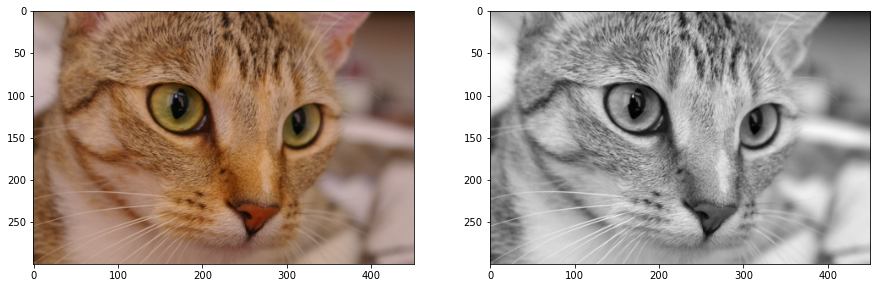

In [3]:
img_rgb = imageio.imread('imageio:chelsea.png')/255
img = rgb2yiq(img_rgb)[:,:,0]

_, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[1].imshow(img, 'gray')

# 1. Transformada Discreta de Fourier 

1. Calcular y mostrar el espectro en módulo y fase de una imagen en escala de grises. Mostrar el módulo en escala logarítmica
2. Encuentre una transformada para la amplitud y una para la fase que permita guardar el espectro en imágenes de 8 bit perdiendo la menor cantidad de información posible
3. Implementar la transformada inversa que convierta el espectro guardado en imágenes de 8 bit en la imagen original 
4. Calcular el error medio cuadrático de ir y volver a la imagen de 8bit
5. Guardar tp4.png como tp4_amp.png y tp4_phase.png. Corregir la tp4_amp.png con MS Paint o similar. Leer el espectro modificado y reconstruir la imagen.

**1.** Calcular y mostrar el espectro en módulo y fase de una imagen en escala de grises. Mostrar el módulo en escala logarítmica

Test point 0: Chequeo img -> fft ->ifft -------------------------------
-----------------------------------------------------------------------
error rmse mínimo a conseguir:  1.69E-16 

Img original: max(), sum():  0.7613882352941176 63387.84759607842
Img img_restore: max(), sum():  0.761388235294118 63387.84759607842


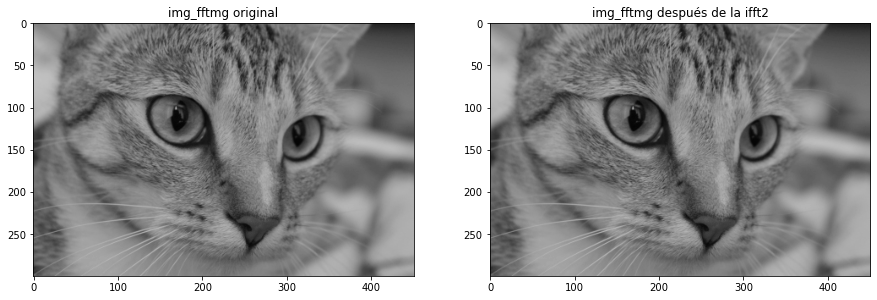

In [4]:
# %% Primer inciso: Etapa 0 - Para chequear
imgin     = imageio.imread('imageio:chelsea.png')/255
debug = 1;
bins = 100;
name_mod2save = 'mod_save.png';
# Se procesa un array2D, o img gray o img L
img = imgin if imgin.ndim==2 else rgb2yiq(imgin)[:,:,0];

filas,cols = img.shape;
K = 1;#(1/(filas*cols));
img_fft = K*fft2(img);
img_restore = np.real(ifft2(img_fft))/K;
error_rmse = np.abs( rmse(img,img_restore));
print('Test point 0: Chequeo img -> fft ->ifft -------------------------------')
print ('-----------------------------------------------------------------------')
print('error rmse mínimo a conseguir: ',format(error_rmse,'.2E'),'\n')

if debug:
    _, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].imshow(img,'gray',vmin=0, vmax=1); ax[0].set_title('img_fftmg original')
    ax[1].imshow(img_restore,'gray', vmin=0, vmax=1);  ax[1].set_title('img_fftmg después de la ifft2')
    print('Img original: max(), sum(): ', img.max(),np.sum(img));
    print('Img img_restore: max(), sum(): ', img_restore.max(),np.sum(img_restore));

max y min en el modulo(sin log()):  6.34E+04  y  1.85E-02
max y min en el modulo(con log()):  1.11E+01  y  -3.99E+00
max y min en fase:  3.14E+00  y  -3.14E+00


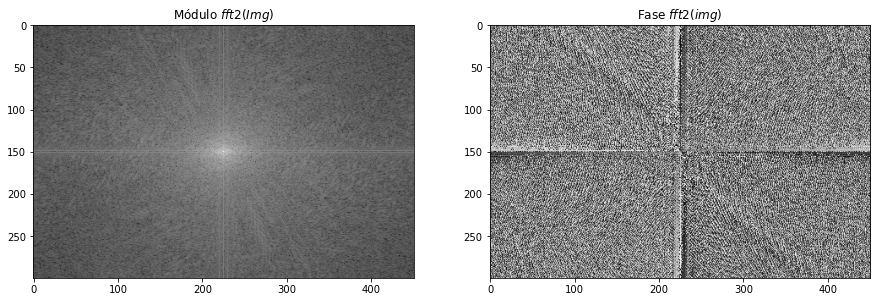

In [5]:
# %% Primer inciso: Etapa 1 - Visualización del espectro en módulo y fase 
img_mod     = np.abs(img_fft);     
img_fase   = np.angle(img_fft);

_, ax1 = plt.subplots(1, 2, figsize=(15,5))
ax1[0].imshow(np.log(fftshift(img_mod)), 'gray'); ax1[0].set_title('Módulo $fft2(Img)$')
ax1[1].imshow(fftshift(img_fase), 'gray');       ax1[1].set_title('Fase $fft2(img)$')
if debug:
    print('max y min en el modulo(sin log()): ',  format(img_mod.max(),'.2E'),' y ',format(img_mod.min(),'.2E'))
    print('max y min en el modulo(con log()): ',  format(np.log(img_mod.max()),'.2E'),' y ',format(np.log(img_mod.min()),'.2E'))
    print('max y min en fase: ', format(img_fase.max(),'.2E'),' y ',format(img_fase.min(),'.2E'))

**2.** Encuentre una transformada para la amplitud y una para la fase que permita guardar el espectro en imágenes de 8 bit perdiendo la menor cantidad de información posible.

**4.** Calcular el error medio cuadrático de ir y volver a la imagen de 8bit.

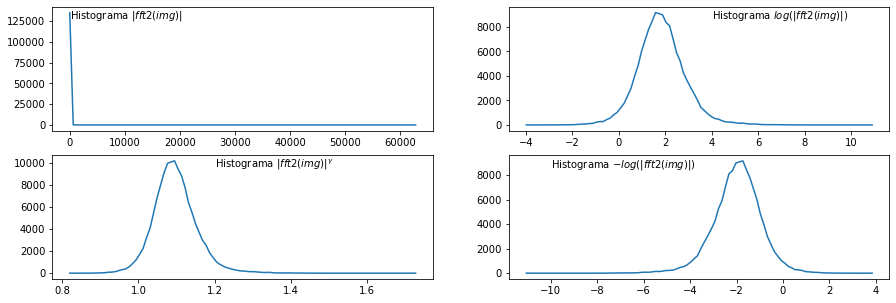

In [6]:
#%% Segundo y Cuarto inciso: Etapa 0 - Análisis de la distribucion de los valores de magnitud
alfa = 1;
gama=1/20;
img_mod_w = img_mod;#np.abs(img_fft);
img_mod_w_log = np.log(np.abs(img_fft));

yp1,xp1 = np.histogram(img_mod_w,bins);
img_mod_w_gamma = alfa*img_mod_w**gama;
yp2,xp2 = np.histogram(img_mod_w_gamma,bins);
yp3,xp3 = np.histogram(img_mod_w_log,bins);
yp4,xp4 = np.histogram(-img_mod_w_log,bins);

# Graficas
_, ax = plt.subplots(2, 2, figsize=(15,5));
ax[0,0].plot(xp1[0:len(xp1)-1],yp1);    #ax[0,0].set_title('Histograma $|fft2(Img)|$')
ax[0,0].text(.3,.9*ax[0,0].get_ylim()[1], 'Histograma $|fft2(img)|$');

ax[1,0].plot(xp2[0:len(xp1)-1],yp2);    #ax[1,0].set_title('Histograma $|fft2(img_fftmg)|^\gamma$')  
ax[1,0].text(1.2,.9*ax[1,0].get_ylim()[1], 'Histograma $|fft2(img)|^\gamma$');

ax[0,1].plot(xp3[0:len(xp1)-1],yp3);    #ax[0,1].set_title('Histograma $log|fft2(Img)|$')
ax[0,1].text(4,.9*ax[0,1].get_ylim()[1], 'Histograma $log(|fft2(img)|)$');

ax[1,1].plot(xp4[0:len(xp1)-1],yp4);    #ax[1,1].set_title('Histograma $-Log|fft2(Img)|$')
ax[1,1].text(-10,.9*ax[1,1].get_ylim()[1], 'Histograma $-log(|fft2(img)|)$');

# Mini conclusiones
# Visualmente, tanto la corrección gamma, como -log, y log consiguen
# distribuciones similares, prometedoras y sencillas de implementar. 

# Se tiene la idea que una distribución uniforme en los *valores del modulo*,
# conseguiria una *minimo mse*. Dado que las distribuciones mostradas pueden modelarle
# con una gausiana, quedo pendiente usar la cdf de la normal como 2da función
# de transformación.

**Mini conclusiones**
- Visualmente, tanto la corrección gamma, como -log, y log consiguen distribuciones similares, prometedoras y sencillas de implementar. 
+ Se tiene la idea que una distribución uniforme en los *valores del modulo*,  conseguiria una *minimo mse*. Dado que las distribuciones mostradas pueden modelarle con una gausiana, quedo pendiente usar la cdf de la normal como 2da función de transformación.

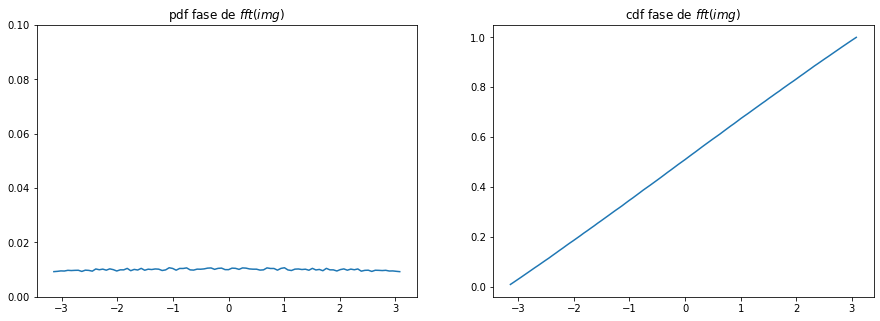

In [7]:
#%% Segundo y Cuarto inciso: Etapa 1 - Análisis de la distribucion de la fase
img_fase_w = img_fase;
yp1,xp1 = np.histogram(img_fase_w,bins);
yp1 = yp1/np.sum(yp1);
_, ax = plt.subplots(1, 2, figsize=(15,5));
ax[0].plot(xp1[0:len(xp1)-1],yp1); ax[0].set_ylim([0,.1])
ax[0].set_title('pdf fase de $fft(img)$');
ax[1].plot(xp1[0:len(xp1)-1],np.cumsum(yp1)); ax[1].set_title('cdf fase de $fft(img)$');

# Mini conclusiones
# Visualmente, podria decirse que la evidencia indica que la fase de esta imagen
# tiene una ditribución uniforme. Por esta razón no se realiza ninguna transformación
# sobre la fase.


 **Mini conclusiones**
 + Visualmente, podria decirse que la evidencia indica que la fase de esta imagen tiene una ditribución uniforme. Por esta razón no se realiza ninguna transformación sobre la fase.

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Test point 1: antes de guardar y despues de leer T{|fft2(img)|} -------
-----------------------------------------------------------------------
max y min en -log|fft2(I) norm|:  1.00E+00  y  0.00E+00
error rmse entre mod_transf_w(antes de guardar) y mod_transf_r(despues de leer):  1.13E-03 



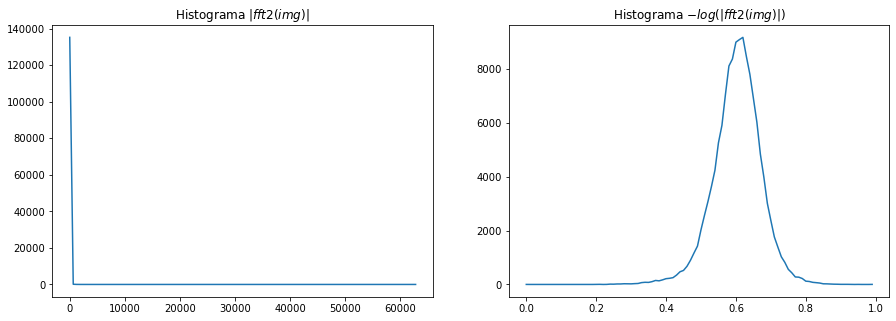

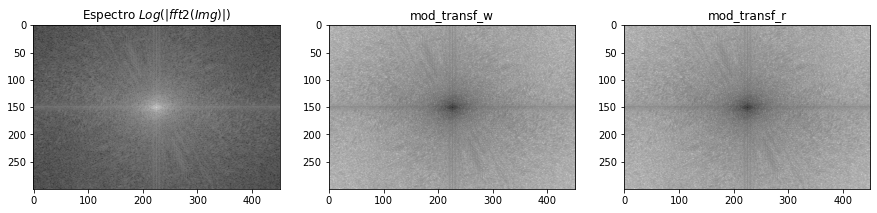

In [8]:
#%% Segundo y Cuarto inciso: Etapa 2 - Transformación y guardado del espectro
#filas,cols = img.shape; K = 1;#(1/(filas*cols)); img_fft = K*fft2(img);

img_mod_w     = np.abs(fft2(img));     

# img_fft transformada con -log()
mod_transf_w = -np.log(img_mod_w);
# img con histograma normalizado
mx = mod_transf_w.max(); mn = mod_transf_w.min();
mod_transf_w = (mod_transf_w-mn)/(mx-mn) 

# Guardado and read
imageio.imwrite(name_mod2save,255*mod_transf_w);
mod_transf_r = imageio.imread(name_mod2save)/255;

print('Test point 1: antes de guardar y despues de leer T{|fft2(img)|} -------')
print ('-----------------------------------------------------------------------')

if debug:
    print('max y min en -log|fft2(I) norm|: ', format(mod_transf_w.max(),'.2E'),' y ',format(mod_transf_w.min(),'.2E'))

    #Graficas
    _, ax = plt.subplots(1, 2, figsize=(15,5));
    yp1,xp1 = np.histogram(img_mod_w,bins);           ax[0].plot(xp1[0:len(xp1)-1],yp1);
    ax[0].set_title( 'Histograma $|fft2(img)|$');   
    yp2,xp2 = np.histogram(mod_transf_w,bins);        ax[1].plot(xp2[0:len(xp2)-1],yp2);
    ax[1].set_title( 'Histograma $-log(|fft2(img)|)$');
    
    _, ax1 = plt.subplots(1, 3, figsize=(15,5));
    ax1[0].imshow(np.log(fftshift(img_mod_w)), 'gray');     ax1[0].set_title('Espectro $Log(|fft2(Img)|)$')
    ax1[1].imshow(fftshift(mod_transf_w), 'gray',vmin=0, vmax=1);  ax1[1].set_title('mod_transf_w');#ax1[1].set_title('Espectro $-log(|fft2(Img)|)$ normalizado')
    ax1[2].imshow(fftshift(mod_transf_r), 'gray',vmin=0, vmax=1);  ax1[2].set_title('mod_transf_r'); #  ax1[2].set_title('Espectro read despues del write')

error_rmse = np.abs( rmse(mod_transf_w,mod_transf_r));
print('error rmse entre mod_transf_w(antes de guardar) y mod_transf_r(despues de leer): ',format(error_rmse,'.2E'),'\n');


**3.** Implementar la transformada inversa que convierta el espectro guardado en imágenes de 8 bit en la imagen original.

**4.** Calcular el error medio cuadrático de ir y volver a la imagen de 8bit.

Test point 2: antes de T y despues T(-1) ------------------------------
-----------------------------------------------------------------------
error rmse entre img_mod_w y img_mod_r:  7.92E-01 

max y min en el img_mod_w(sin log()):  6.34E+04  y  1.85E-02
max y min en el img_mod_r(sin log()):  6.34E+04  y  1.85E-02


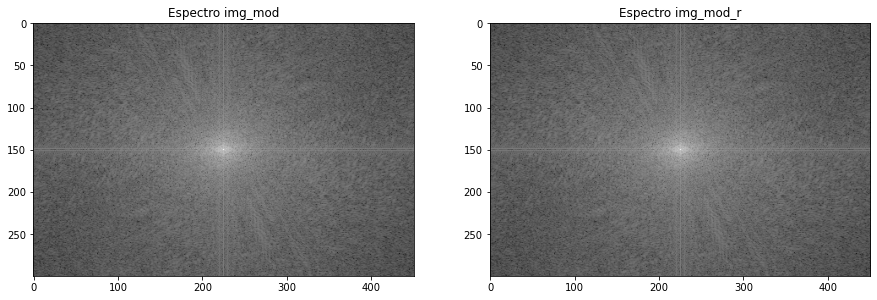

In [9]:
#%% Tercer y Cuarto inciso: Etapa 0 - Transformación inversa
# Medicion del modulo del espectro despues de la transformación ^(-1)
# transformación ^(-1)
x = (mx-mn)*mod_transf_r + mn;
img_mod_r = np.exp(-x);
error_rmse = np.abs( rmse(img_mod_w,img_mod_r));

print('Test point 2: antes de T y despues T(-1) ------------------------------')
print ('-----------------------------------------------------------------------')
print('error rmse entre img_mod_w y img_mod_r: ',format(error_rmse,'.2E'),'\n');

if debug:
# Test point
    print('max y min en el img_mod_w(sin log()): ',  format(img_mod_w.max(),'.2E'),' y ',format(img_mod_w.min(),'.2E'));
    print('max y min en el img_mod_r(sin log()): ',  format(img_mod_r.max(),'.2E'),' y ',format(img_mod_r.min(),'.2E'))

    _, ax1 = plt.subplots(1, 2, figsize=(15,5));
    ax1[0].imshow(np.log(fftshift(img_mod_w)), 'gray');     ax1[0].set_title('Espectro img_mod')
    ax1[1].imshow(np.log(fftshift(img_mod_r)), 'gray');     ax1[1].set_title('Espectro img_mod_r');


In [10]:
#%% Tercer y Cuarto inciso: Etapa 1 - modulo y fase ->fft_restore
# math.exp() # es mas rapido
# np.exp() # es mas rapido que math,
#fase_sint = np.pi*uniform.rvs(2.32e-5,1,[filas, cols]);
#img_fft_r = np.multiply( img_mod_w,np.exp(1j*fase_sint) );
img_fft_r = np.multiply( img_mod_w,np.exp(1j*img_fase) );

print('Test point 3: modulo y fase -> fft_r  vs fft(img) inicial -------------')
print ('-----------------------------------------------------------------------')
error_rmse = np.abs( rmse(img_fft,img_fft_r));
print('error rmse entre img_fft y img_fft_r: ',format(error_rmse,'.2E'),'\n');

Test point 3: modulo y fase -> fft_r  vs fft(img) inicial -------------
-----------------------------------------------------------------------
error rmse entre img_fft y img_fft_r:  1.54E-15 



Test point 4: nivel pixeles -------------------------------------------
-----------------------------------------------------------------------
error rmse a nivel pixel:  1.668771735524458e-16


Text(0.5, 1.0, 'img después de leer y revertir el procedimiento')

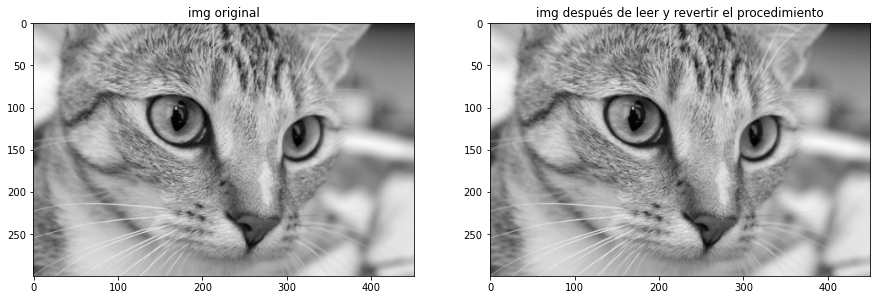

In [11]:
#%% Tercer y Cuarto inciso: Etapa 2 - nivel pixeles
img_r = ifft2(img_fft_r);
error_rmse = np.abs( rmse(img,img_r));

print('Test point 4: nivel pixeles -------------------------------------------')
print ('-----------------------------------------------------------------------')
print('error rmse a nivel pixel: ',error_rmse);

# Graficas
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(img,'gray');    ax[0].set_title('img original')
ax[1].imshow(np.real(img_r),'gray');  ax[1].set_title('img después de leer y revertir el procedimiento')


**5.** Guardar tp4.png como tp4_amp.png y tp4_phase.png. Corregir la tp4_amp.png con MS Paint o similar. Leer el espectro modificado y reconstruir la imagen.

Lossy conversion from float64 to uint8. Range [-3.141574116327592, 3.141592653589793]. Convert image to uint8 prior to saving to suppress this warning.


Text(0.5, 1.0, 'Imagen corregida')

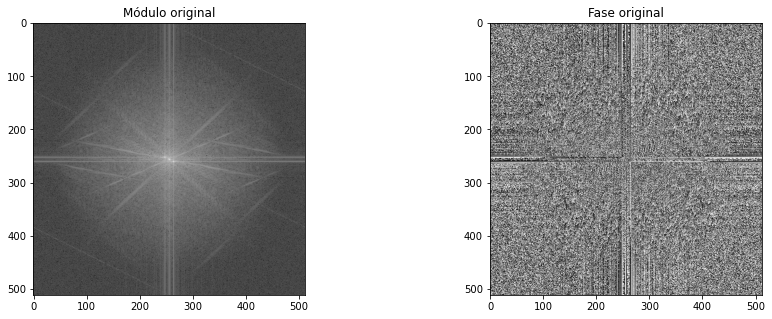

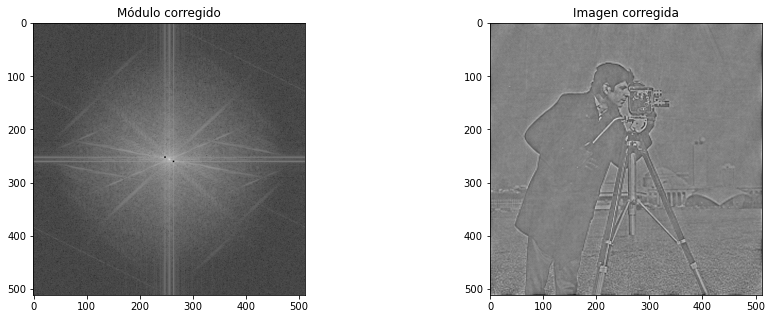

In [3]:
#%% Quinto inciso: 

import imageio
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2,ifft2,fftshift

img = imageio.imread('tp4.png')/255;
# plt.imshow(img,'gray');
img_fft = fftshift(fft2(img));
img_mod = np.log( np.abs(img_fft) );
img_fase = np.angle(img_fft);

#%%
_, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].imshow(img_mod, 'gray'); ax[0].set_title('Módulo original')
ax[1].imshow(img_fase, 'gray');       ax[1].set_title('Fase original')
mx = img_mod.max(); mn = img_mod.min();
img_mod_norm = 255*(img_mod-mn)/(mx-mn); 

imageio.imwrite('tp4_amp.png',img_mod_norm.astype(np.uint8));
imageio.imwrite('tp4_phase.png',img_fase);
#%%
img_mod_r = imageio.imread('tp4_amp_filter.png')[...,0]/255;
img_mod_filter = (mx-mn)*img_mod_r + mn;
img_fft_r = np.multiply( img_mod_filter,np.exp(1j*img_fase) );
img_restore = np.real(ifft2(fftshift(img_fft_r)));

_, ax1 = plt.subplots(1, 2, figsize=(15,5))
ax1[0].imshow(img_mod_filter, 'gray'); ax1[0].set_title('Módulo corregido')
ax1[1].imshow(img_restore, 'gray');       ax1[1].set_title('Imagen corregida')